This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds a run-specific estimator for intensity delta.

X is a sequence's attributes in a run:
- log2 intensity
- uncalibrated m/z (the raw intensity as extracted by TFD)
- charge
- retention time
- CCS

y is the delta of intensity in a run from the median intensity of the sequence over the experiment.

For training, filter:
- human only
- only sequences detected in at least half the runs
- only 1to1 runs

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'

In [5]:
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features/extracted-features.sqlite".format(EXPERIMENT_DIR)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)


In [6]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [7]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted from features where (rt_apex is not null) and (scan_apex is not null)', db_conn)
db_conn.close()


In [8]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [9]:
len(sequences_df)

532925

In [10]:
# find the experiment-wide means and std devs for m/z, CCS, RT
experiment_means_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # m/z
    experiment_mz_mean = np.mean(group_df.monoisotopic_mz_centroid)
    experiment_mz_std_dev = np.std(group_df.monoisotopic_mz_centroid)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_mz_mean','experiment_mz_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev'])


In [11]:
sequences_df = pd.merge(sequences_df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


#### Note that from now on we work with intensity and intensity delta in log2 space. The median is the median of log2(intensity).

In [12]:
sequences_df['delta_intensity'] = sequences_df.log_intensity - sequences_df.experiment_intensity_mean


In [13]:
run_name = '190719_Hela_Ecoli_1to1_01'
file_idx = file_idx_for_run(run_name)

In [14]:
minimum_number_of_runs_for_training_set = 10

In [15]:
# make the training set from human only, comprising sequences we have identified in a minimum of runs
high_frequency_human_sequences_df = sequences_df[(sequences_df.human == True) & (sequences_df.number_of_runs_extracted > minimum_number_of_runs_for_training_set)].copy()

proportion_to_subsample = 0.2
number_to_subsample = int(proportion_to_subsample * len(high_frequency_human_sequences_df))
training_set_all_runs_df = high_frequency_human_sequences_df.sample(n=number_to_subsample)
print("training set is {}% of all human sequences.".format(round(len(training_set_all_runs_df) / len(sequences_df[(sequences_df.human == True)]) * 100, 1)))

training set is 19.4% of all human sequences.


In [16]:
print("training set is {}% of the experiment.".format(round(len(training_set_all_runs_df) / len(sequences_df) * 100, 1)))

training set is 15.6% of the experiment.


In [17]:
training_set_selected_run_df = training_set_all_runs_df[training_set_all_runs_df.file_idx == file_idx]

In [18]:
training_set_selected_run_df.sample(5)

,sequence,charge,file_idx,intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,...,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,delta_intensity
374066,Q[-17.0265]CLSLRPAPAM[15.9949]R,2,11,313,1397.691120,699.852836,526.193189,609.0,190719_Hela_Ecoli_1to1_01,1to1,...,8.290019,8.964791,1.339544,699.853831,0.001377,531.388513,11.013815,640.35,28.691941,-0.674772
178301,GNETQLM[15.9949]LNSLQPNK,2,11,8251,1701.834418,851.924485,740.979353,306.0,190719_Hela_Ecoli_1to1_01,1to1,...,13.010353,12.734411,0.184859,851.924752,0.000433,736.528477,3.169860,302.05,2.923611,0.275942
264746,LDVATDNFFQNPELYIR,2,11,2960,2054.012822,1028.013687,983.372623,274.0,190719_Hela_Ecoli_1to1_01,1to1,...,11.531381,11.125022,0.552099,1028.013991,0.000266,977.458486,3.498152,272.35,7.185228,0.406359
381259,Q[-17.0265]QMLENQM[15.9949]EVRKK,2,11,8190,1659.801528,830.908040,821.221771,419.0,190719_Hela_Ecoli_1to1_01,1to1,...,12.999648,10.767223,1.692138,830.910254,0.001669,834.186144,12.840464,481.00,30.613338,2.232425
476621,VFNELLVLLPDTAK,2,11,7192,1570.897351,786.455951,1065.790036,488.0,190719_Hela_Ecoli_1to1_01,1to1,...,12.812177,12.918801,0.158997,786.455474,0.001056,1060.391125,3.458710,490.55,7.060276,-0.106623


In [19]:
len(training_set_selected_run_df)

4283

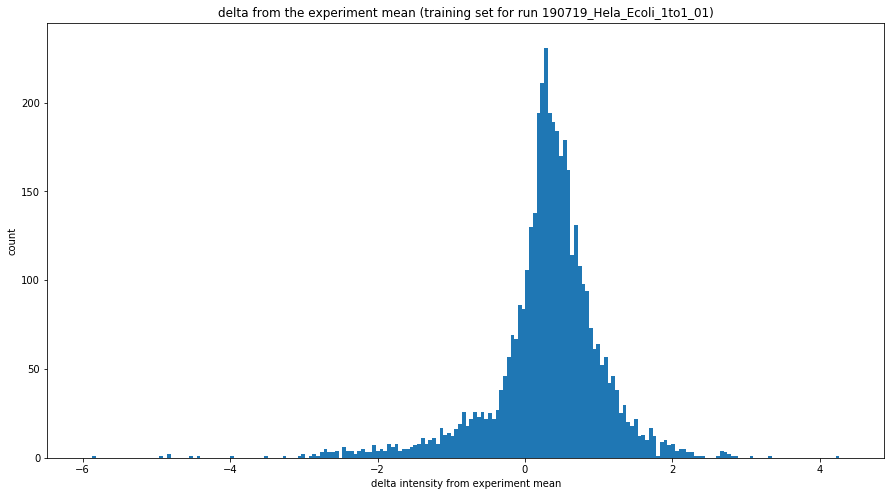

In [20]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 200
hist, bins, _ = plt.hist(training_set_selected_run_df.delta_intensity, bins=bins)
plt.xlabel('delta intensity from experiment mean')
plt.ylabel('count')
plt.title('delta from the experiment mean (training set for run {})'.format(run_name))

plt.show()

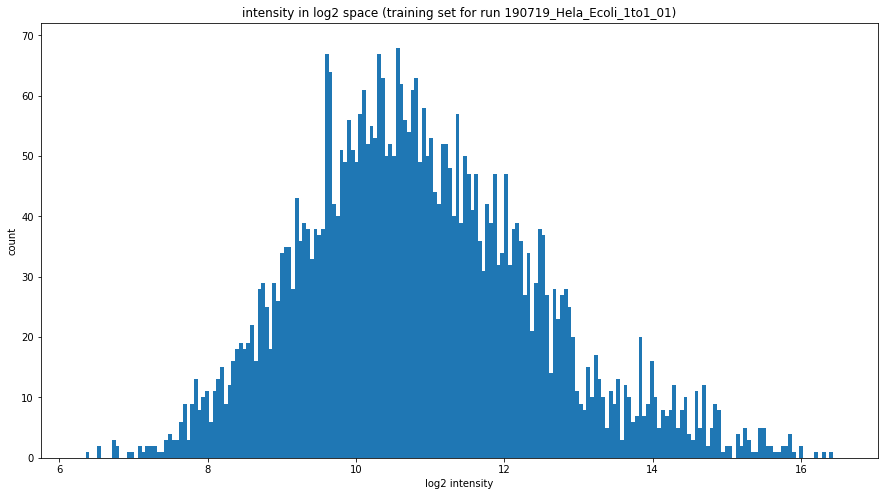

In [21]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 200
hist, bins, _ = plt.hist(training_set_selected_run_df.log_intensity, bins=bins)
plt.xlabel('log2 intensity')
plt.ylabel('count')
plt.title('intensity in log2 space (training set for run {})'.format(run_name))

plt.show()

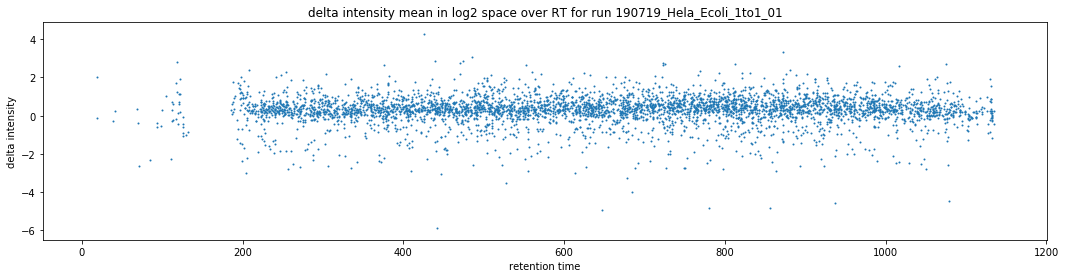

In [22]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.rt_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
# plt.xlim((300,400))
# plt.ylim((-2,2))

plt.show()

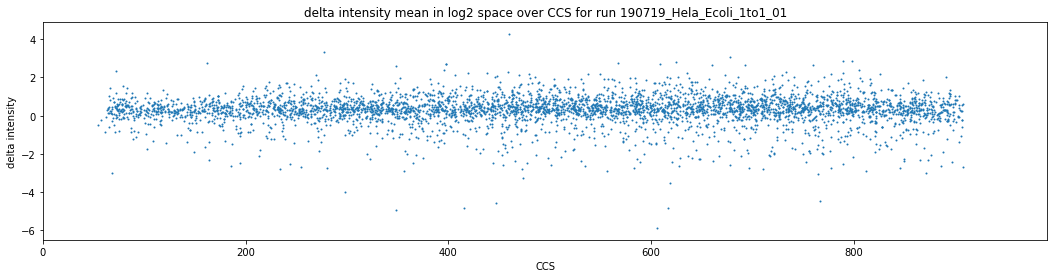

In [23]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.scan_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((0,991))
# plt.ylim((-2,2))

plt.show()

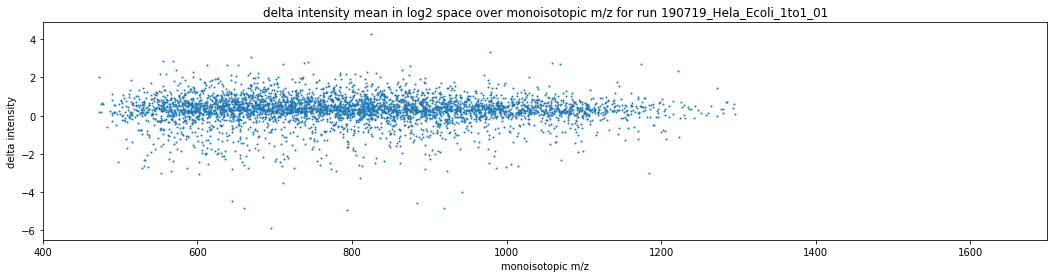

In [24]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.monoisotopic_mz_centroid, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over monoisotopic m/z for run {}'.format(run_name))
plt.xlim((400,1700))
# plt.ylim((-3,3))

plt.show()

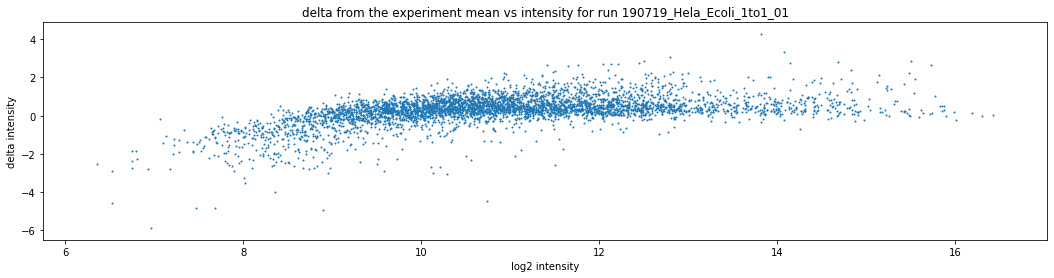

In [25]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.log_intensity, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('log2 intensity')
plt.title('delta from the experiment mean vs intensity for run {}'.format(run_name))
# plt.xlim((400,1700))

plt.show()

#### create a gradient boosted regressor model

In [26]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_distributions=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


#### train a model for a selected run

In [27]:
training_set_selected_run_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'monoisotopic_mass',
       'monoisotopic_mz_centroid', 'rt_apex', 'scan_apex', 'run_name', 'batch',
       'human', 'number_of_runs_extracted', 'log_intensity',
       'experiment_intensity_mean', 'experiment_intensity_std_dev',
       'experiment_mz_mean', 'experiment_mz_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'delta_intensity'],
      dtype='object')

In [28]:
# training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex','charge','log_intensity','experiment_intensity_mean', 'experiment_intensity_std_dev',
#        'experiment_mz_mean', 'experiment_mz_std_dev', 'experiment_rt_mean',
#        'experiment_rt_std_dev', 'experiment_scan_mean',
#        'experiment_scan_std_dev']

training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex']

In [29]:
training_set_selected_run_df[training_attributes].sample(10)

,monoisotopic_mz_centroid,rt_apex,scan_apex
366390,927.459227,216.331355,272.0
286975,1124.018826,791.679161,113.0
221228,880.965041,710.918138,176.0
455676,751.369576,441.546211,572.0
209477,1126.204170,725.651727,330.0
442598,936.995649,1061.541971,297.0
226018,993.016793,872.862643,234.0
344079,592.771559,474.535678,778.0
233983,582.288993,343.752549,809.0
463741,761.889203,541.088638,536.0


In [30]:
# split the training set
X = training_set_selected_run_df[training_attributes].values
y = training_set_selected_run_df[['delta_intensity']].values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [31]:
len(X_train), len(X_test)

(3854, 429)

In [32]:
# search for the best model in the specified hyperparameter space
parameter_search_space = {'n_estimators':[500, 800, 1000, 2000, 3000], 
                          'learning_rate': [0.1, 0.05, 0.02, 0.01], 
                          'max_depth':[20, 10, 6, 4], 
                          'min_samples_leaf':[3, 5, 9, 17], 
                          'max_features':[1.0, 0.3, 0.1],
                          'loss':['ls', 'lad', 'huber', 'quantile']
                         }
n_jobs = 14
cv, best_estimator = GradientBooster(parameter_search_space, n_jobs, X_train, y_train)


best estimator found: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='lad', max_depth=4,
                          max_features=0.1, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [33]:
# create the model we will use
params = {'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 3, 'max_features': 0.1, 'loss':'lad'}
best_estimator = GradientBoostingRegressor(**params)


In [34]:
# train the model
best_estimator.fit(X_train, y_train)
train_score = best_estimator.score(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)
print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

R-squared for training set: 0.1, test set: 0.0


#### Plot the intensity error

In [35]:
feature_names = np.array(training_attributes)

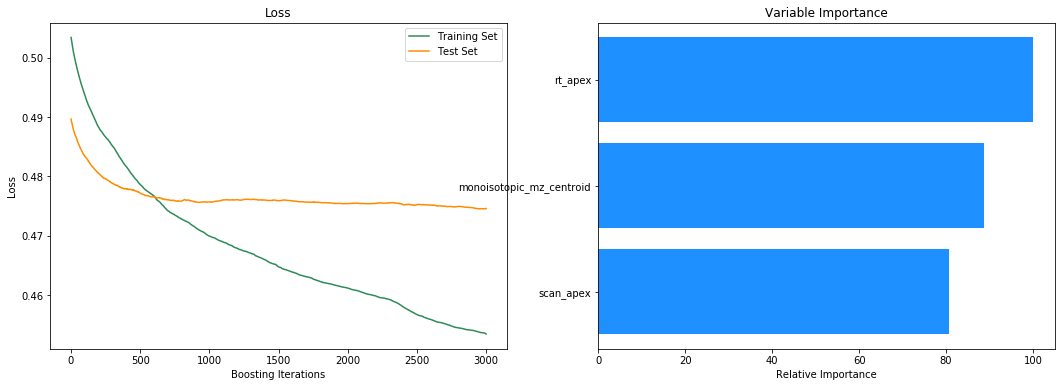

In [36]:
# Plot training loss

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test, y_pred)

plt.figure(figsize=(18, 6))
plt.margins(0.06)
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(params['n_estimators']) + 1, best_estimator.train_score_, 'seagreen', label='Training Set')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'darkorange', label='Test Set')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center', color='dodgerblue')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [37]:
# use the trained model to predict the intensity delta for the test set
y_test_predicted = best_estimator.predict(X_test)

#### train a model for each of the runs

In [38]:
mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)

In [39]:
for mapping in mapping_l:
    file_idx_for_this_model = mapping[0]
    
    # filter out rows we don't want in the training set for this run-specific model
    training_set_for_run_df = training_set_all_runs_df[(training_set_all_runs_df.file_idx == file_idx_for_this_model)]
    print("there are {} sequences in the training set for file {}".format(len(training_set_for_run_df), file_idx_for_this_model))

    # split the training set
    X = training_set_for_run_df[training_attributes].values
    y = training_set_for_run_df[['delta_intensity']].values[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # train the model
    best_estimator.fit(X_train, y_train)
    train_score = best_estimator.score(X_train, y_train)
    test_score = best_estimator.score(X_test, y_test)
    print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

    # save the trained model
    MODEL_FILE_NAME = '{}/intensity-models/file-{}-intensity-model.pkl'.format(EXPERIMENT_DIR, file_idx_for_this_model)
    with open(MODEL_FILE_NAME, 'wb') as file:
        pickle.dump(best_estimator, file)

there are 4128 sequences in the training set for file 0
R-squared for training set: 0.1, test set: 0.0
there are 4238 sequences in the training set for file 1
R-squared for training set: 0.2, test set: 0.0
there are 4092 sequences in the training set for file 2
R-squared for training set: 0.2, test set: 0.1
there are 4150 sequences in the training set for file 3
R-squared for training set: 0.1, test set: 0.0
there are 4051 sequences in the training set for file 4
R-squared for training set: 0.1, test set: 0.0
there are 4220 sequences in the training set for file 5
R-squared for training set: 0.1, test set: 0.0
there are 4328 sequences in the training set for file 6
R-squared for training set: 0.1, test set: -0.0
there are 4141 sequences in the training set for file 7
R-squared for training set: 0.1, test set: 0.0
there are 4090 sequences in the training set for file 8
R-squared for training set: 0.1, test set: 0.0
there are 4226 sequences in the training set for file 9
R-squared for tr

#### use the run-specific models to estimate the delta intensity for all sequences in all runs

In [40]:
normalised_intensities_l = []
for mapping in mapping_l:
    file_idx = mapping[0]
    print("file {}".format(file_idx))
    
    # load the model for this run
    MODEL_FILE_NAME = '{}/intensity-models/file-{}-intensity-model.pkl'.format(EXPERIMENT_DIR, file_idx)
    with open(MODEL_FILE_NAME, 'rb') as file:
        estimator = pickle.load(file)
    
    # get the sequences in this run
    run_df = sequences_df[sequences_df.file_idx == file_idx].copy()
    
    # build the list of sequences for inference
    X = run_df[training_attributes].values

    # predict the log2 delta intensity for each sequence in the run
    y = estimator.predict(X)
    
    run_df['estimated_delta_intensity'] = y
    run_df['normalised_log_intensity'] = run_df.log_intensity - y
    run_df['normalised_intensity'] = np.power(2, run_df.normalised_log_intensity)
    
    normalised_intensities_l.append(run_df[['sequence','charge','file_idx','estimated_delta_intensity','normalised_log_intensity','normalised_intensity']])

# make a single df from the list of dfs
normalised_intensities_df = pd.concat(normalised_intensities_l, axis=0, sort=False)

# add the normalised intensity columns with the sequences
sequences_df = pd.merge(sequences_df, normalised_intensities_df, how='left', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])


file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19


In [41]:
# did any gaps creep in?
sequences_df[sequences_df.isnull().any(axis=1)]

,sequence,charge,file_idx,intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,...,experiment_mz_mean,experiment_mz_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,delta_intensity,estimated_delta_intensity,normalised_log_intensity,normalised_intensity


In [43]:
sequences_human_1to1_df = sequences_df[(sequences_df.human == True) & (sequences_df.batch == '1to1')]
sequences_human_1to3_df = sequences_df[(sequences_df.human == True) & (sequences_df.batch == '1to3')]
sequences_ecoli_1to1_df = sequences_df[(sequences_df.human == False) & (sequences_df.batch == '1to1')]
sequences_ecoli_1to3_df = sequences_df[(sequences_df.human == False) & (sequences_df.batch == '1to3')]


#### plot the CVs before and after normalisation

In [44]:
sequence_cv_by_batch_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','batch','human'], as_index=False):
    if len(group_df) > 1:
        sequence = group_name[0]
        charge = group_name[1]
        batch = group_name[2]
        human = group_name[3]
        intensity_cv_before_normalisation = np.std(group_df.intensity) / np.mean(group_df.intensity)
        intensity_cv_after_normalisation = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_by_batch_l.append((sequence, charge, batch, human, intensity_cv_before_normalisation, intensity_cv_after_normalisation))
sequence_cv_groups_df = pd.DataFrame(sequence_cv_by_batch_l, columns=['sequence','charge','batch','human','intensity_cv_before_normalisation', 'intensity_cv_after_normalisation'])

In [45]:
sequence_cv_groups_df.sample(5)

,sequence,charge,batch,human,intensity_cv_before_normalisation,intensity_cv_after_normalisation
35739,MNPDGIFLSNGPGDPAPCDYAITAIQK,3,1to3,0,0.306748,0.296030
11625,EGTSAVENLNEMQCMWFQTECAQAYK,3,1to3,1,0.052453,0.031597
881,ADQELMTYSHDNIICGITSVSFSK,3,1to1,1,0.536662,0.519221
48803,TETVEEPM[15.9949]EEEEAAK,2,1to3,1,0.233114,0.234936
15294,FDYSGVGSSDGNSEESTLGK,2,1to1,1,0.204071,0.168242


In [46]:
human_1to1_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == True) & (sequence_cv_groups_df.batch == '1to1')]
human_1to3_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == True) & (sequence_cv_groups_df.batch == '1to3')]
ecoli_1to1_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == False) & (sequence_cv_groups_df.batch == '1to1')]
ecoli_1to3_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == False) & (sequence_cv_groups_df.batch == '1to3')]

##### human only, 1:1

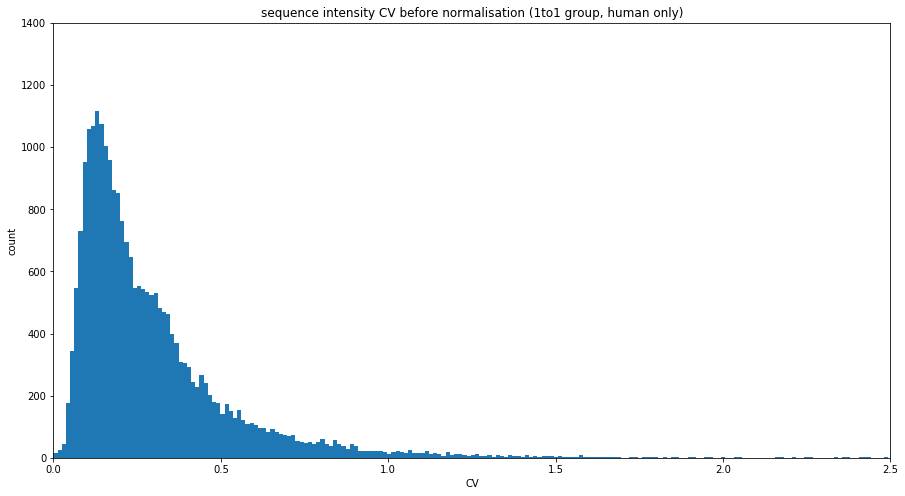

In [69]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV before normalisation (1to1 group, human only)')

bins = 200
hist, bins, _ = plt.hist(human_1to1_df.intensity_cv_before_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.xlim((0,2.5))
plt.ylim((0,1400))

plt.show()

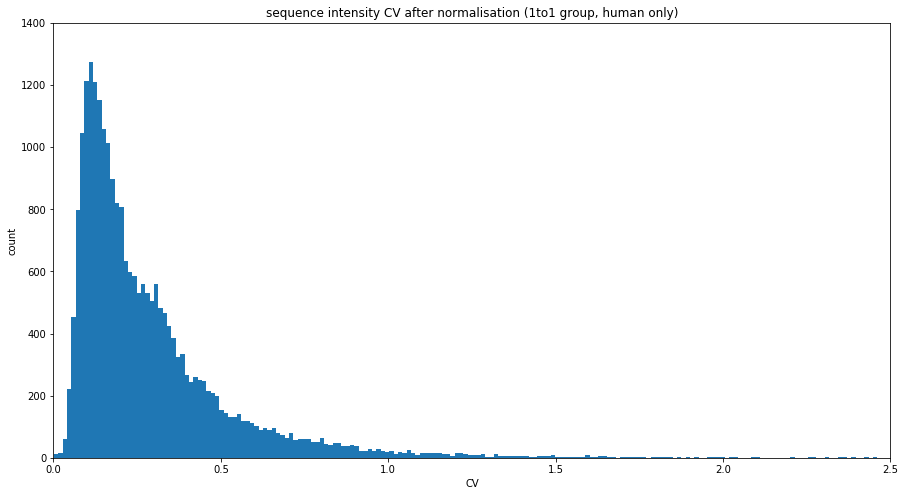

In [70]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV after normalisation (1to1 group, human only)')

bins = 200
hist, bins, _ = plt.hist(human_1to1_df.intensity_cv_after_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.xlim((0,2.5))
plt.ylim((0,1400))

plt.show()

##### E.coli only, 1:1

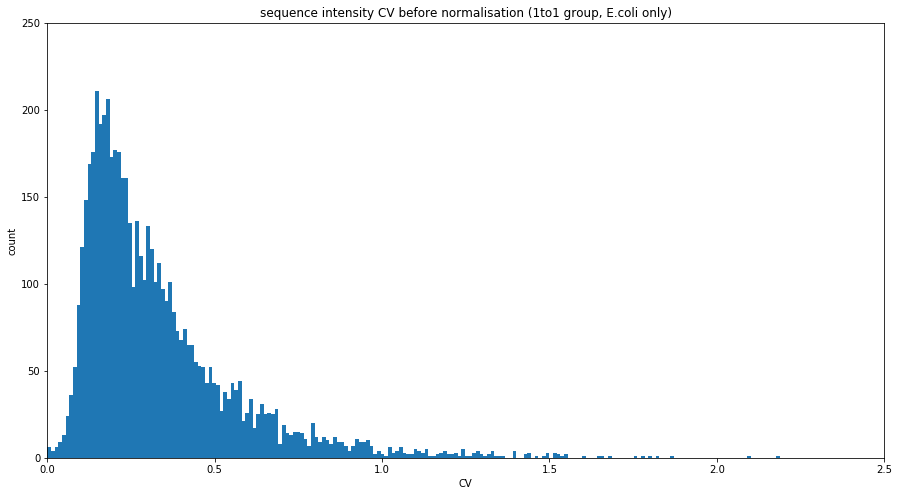

In [71]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV before normalisation (1to1 group, E.coli only)')

bins = 200
hist, bins, _ = plt.hist(ecoli_1to1_df.intensity_cv_before_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.xlim((0,2.5))
plt.ylim((0,250))

plt.show()

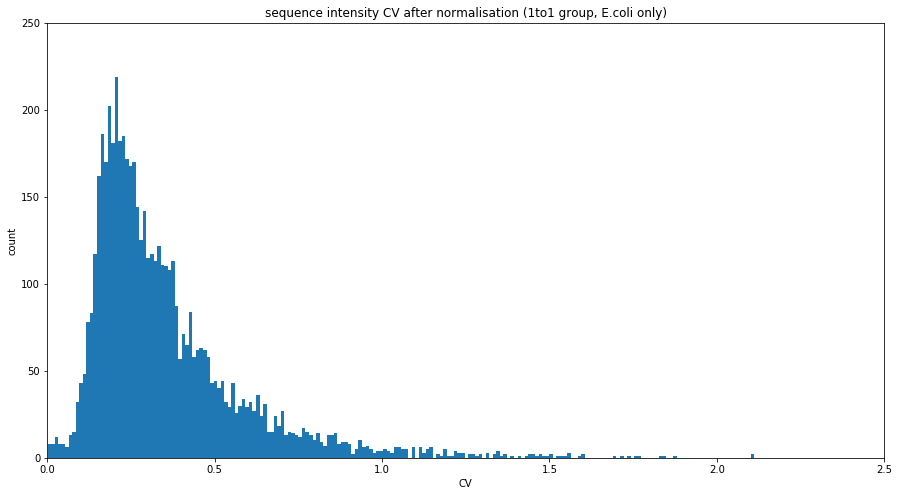

In [72]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV after normalisation (1to1 group, E.coli only)')

bins = 200
hist, bins, _ = plt.hist(ecoli_1to1_df.intensity_cv_after_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.xlim((0,2.5))
plt.ylim((0,250))

plt.show()

#### plot the CV between runs

In [51]:
run_name_A = '190719_Hela_Ecoli_1to1_01'
run_file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
run_file_idx_B = file_idx_for_run(run_name_B)

run_name_C = '190719_Hela_Ecoli_1to1_03'
run_file_idx_C = file_idx_for_run(run_name_C)

In [52]:
three_runs_df = sequences_df[sequences_df.file_idx.isin([run_file_idx_A,run_file_idx_B,run_file_idx_C])]

In [53]:
sequence_cv_l = []
for group_name,group_df in three_runs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    if len(group_df.file_idx.unique()) == 3:  # if the sequence is in all three runs
        intensity_cv_before_normalisation = np.std(group_df.intensity) / np.mean(group_df.intensity)
        intensity_cv_after_normalisation = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_l.append((sequence, charge, intensity_cv_before_normalisation, intensity_cv_after_normalisation))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv_before_normalisation','intensity_cv_after_normalisation'])


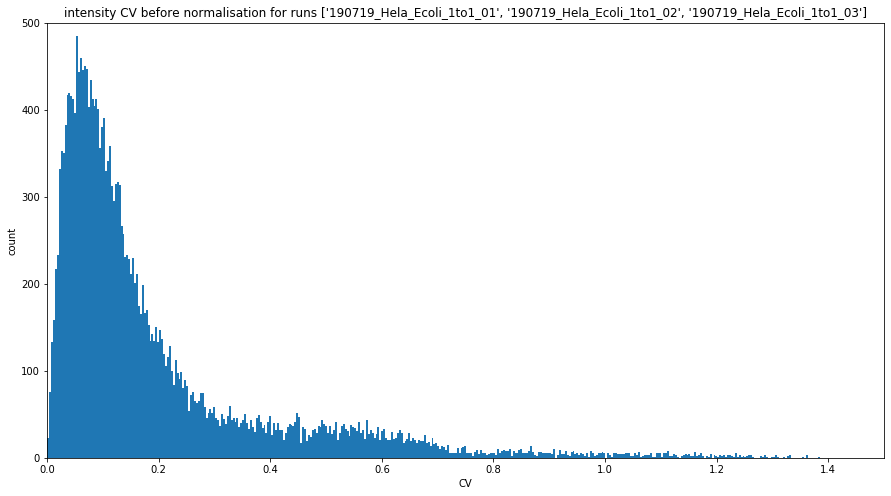

In [73]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity CV before normalisation for runs {}'.format([run_name_A,run_name_B,run_name_C]))

bins = 400
hist, bins, _ = plt.hist(sequence_cv_df.intensity_cv_before_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.xlim((0,1.5))
plt.ylim((0,500))

plt.show()

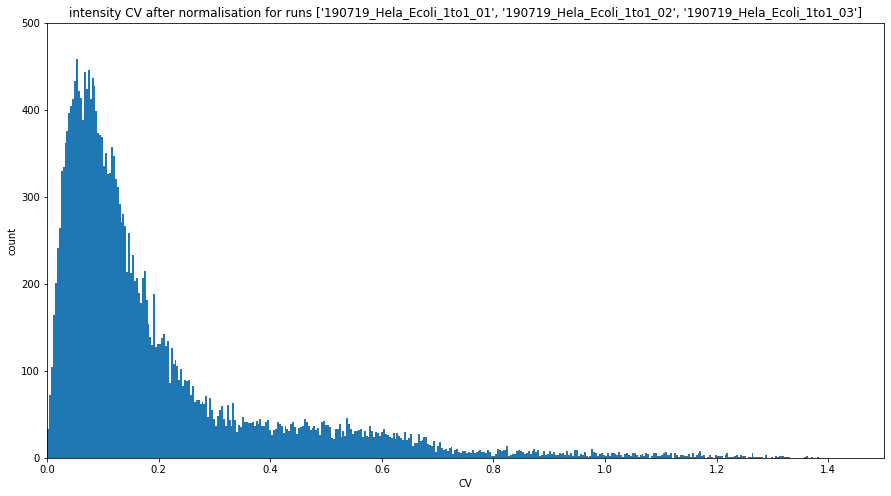

In [74]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity CV after normalisation for runs {}'.format([run_name_A,run_name_B,run_name_C]))

bins = 400
hist, bins, _ = plt.hist(sequence_cv_df.intensity_cv_after_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.xlim((0,1.5))
plt.ylim((0,500))

plt.show()

#### plot the delta intensity between run 01 and 02

In [56]:
run_name_A = '190719_Hela_Ecoli_1to1_01'
run_file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
run_file_idx_B = file_idx_for_run(run_name_B)


In [57]:
runs_AB_df = sequences_df[sequences_df.file_idx.isin([run_file_idx_A,run_file_idx_B])]

In [58]:
sequence_intensity_delta_l = []
for group_name,group_df in runs_AB_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    if len(group_df.file_idx.unique()) == 2:  # if the sequence is in both runs
        # intensity before normalisation
        intensity_A = group_df[group_df.file_idx == run_file_idx_A].iloc[0].intensity
        intensity_B = group_df[group_df.file_idx == run_file_idx_B].iloc[0].intensity
        intensity_delta_before_normalisation = intensity_A - intensity_B
        # intensity after normalisation
        normalised_intensity_A = group_df[group_df.file_idx == run_file_idx_A].iloc[0].normalised_intensity
        normalised_intensity_B = group_df[group_df.file_idx == run_file_idx_B].iloc[0].normalised_intensity
        intensity_delta_after_normalisation = normalised_intensity_A - normalised_intensity_B
        # apexes
        rt_apex = group_df.rt_apex.iloc[0]
        scan_apex = group_df.scan_apex.iloc[0]
        mz_apex = group_df.monoisotopic_mz_centroid.iloc[0]
        sequence_intensity_delta_l.append((sequence, charge, rt_apex, scan_apex, mz_apex, intensity_delta_before_normalisation, intensity_delta_after_normalisation))
sequence_intensity_delta_df = pd.DataFrame(sequence_intensity_delta_l, columns=['sequence','charge','rt_apex','scan_apex','mz_apex','intensity_delta_before_normalisation','intensity_delta_after_normalisation'])


In [59]:
sequence_intensity_delta_df.sample(n=5)

,sequence,charge,rt_apex,scan_apex,mz_apex,intensity_delta_before_normalisation,intensity_delta_after_normalisation
19500,SLVEIIEHGLVDEQQK,2,907.058305,293.0,918.992052,388,279.550435
3016,DHADSNIVIMLVGNK,2,821.221771,481.0,813.418456,373,308.558265
15119,MLVLDEADEMLNK,2,842.418947,556.0,760.870539,67,24.489105
7696,GEFYTQDGVLVASTVQEGVMR,2,820.147948,82.0,1143.557270,-26,-127.870877
1718,ASILNTWISLK,2,927.031072,735.0,623.364105,-2679,-1479.876544


/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log2
  


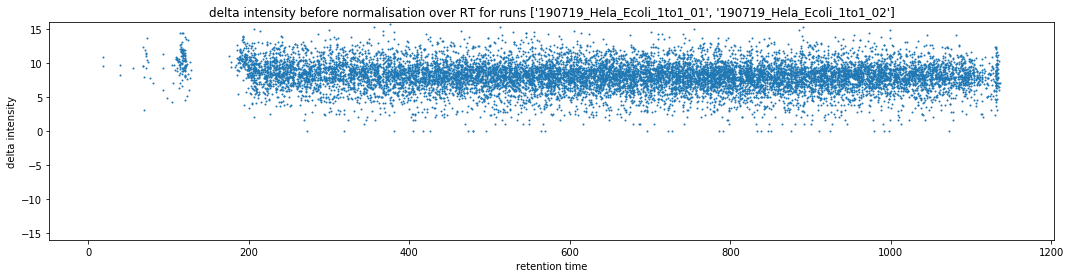

In [60]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequence_intensity_delta_df.rt_apex, np.log2(sequence_intensity_delta_df.intensity_delta_before_normalisation), marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
plt.title('delta intensity before normalisation over RT for runs {}'.format([run_name_A,run_name_B]))
# plt.xlim((0,991))
plt.ylim((-16,16))

plt.show()

/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log2
  


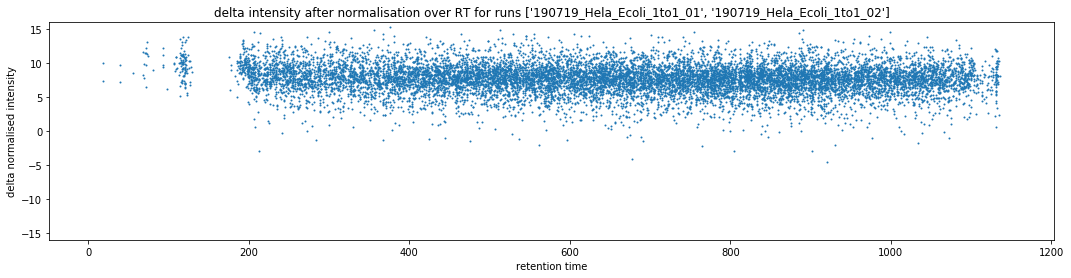

In [61]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequence_intensity_delta_df.rt_apex, np.log2(sequence_intensity_delta_df.intensity_delta_after_normalisation), marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta normalised intensity')
plt.xlabel('retention time')
plt.title('delta intensity after normalisation over RT for runs {}'.format([run_name_A,run_name_B]))
# plt.xlim((0,991))
plt.ylim((-16,16))

plt.show()

#### did we lose the separation between human and Ecoli?

In [62]:
NUMBER_OF_1TO1_RUNS = 10
NUMBER_OF_1TO3_RUNS = 10

In [63]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.normalised_log_intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.normalised_log_intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [64]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [65]:
# sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 - sequence_occurences_in_batch_df.intensity_1to1


In [66]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

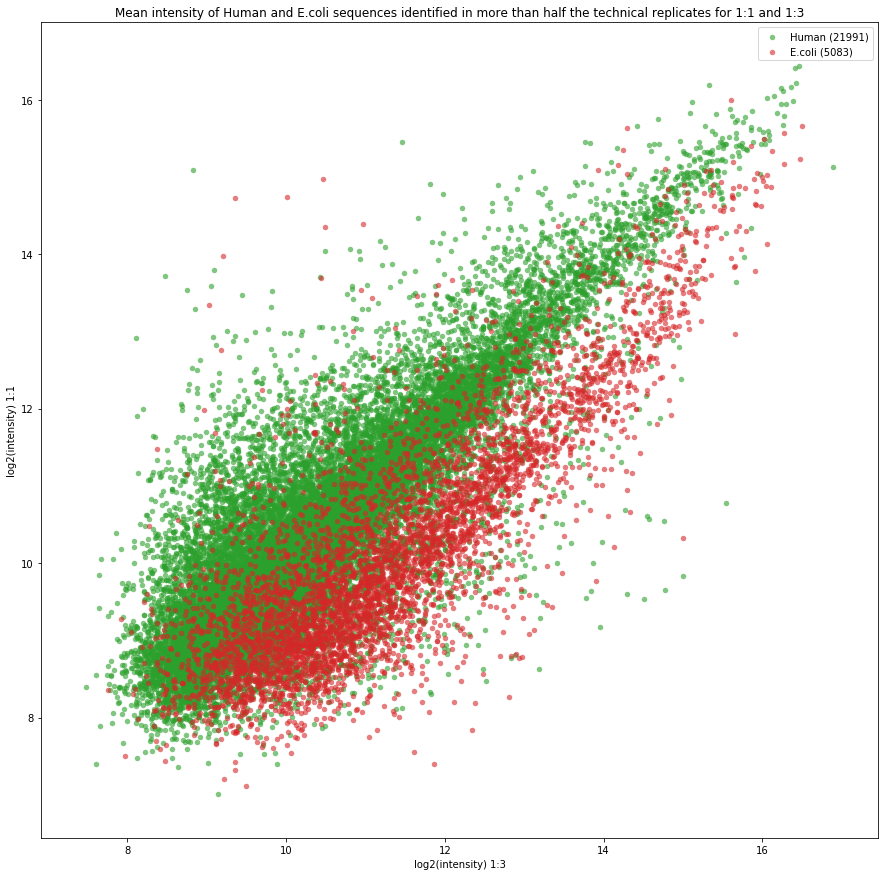

In [67]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(human_df.intensity_1to3, human_df.intensity_1to1, marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(ecoli_df.intensity_1to3, ecoli_df.intensity_1to1, marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

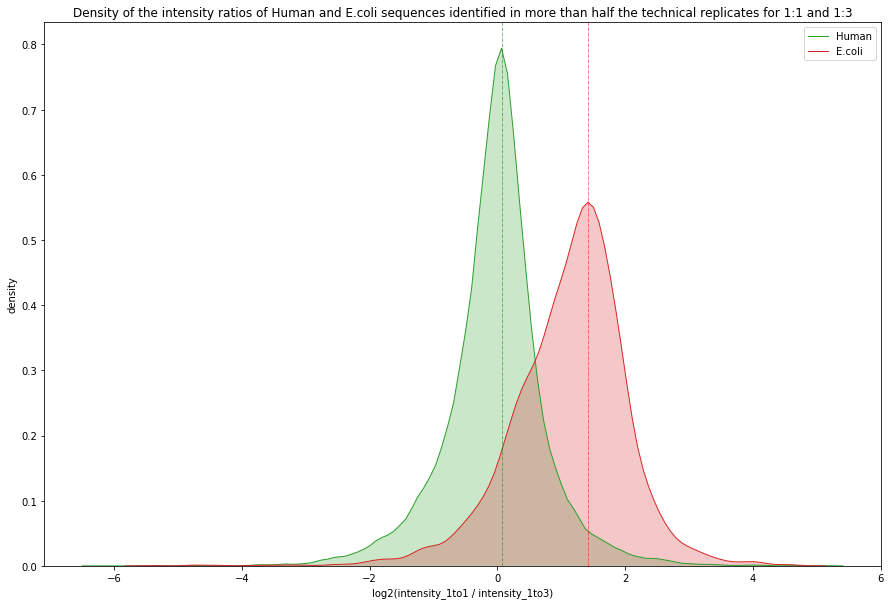

In [68]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(human_df['intensity_ratio'], hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(ecoli_df['intensity_ratio'], hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')